## 多层感知机
### 隐藏层
softmax回归的模型基于一个假设，即目标函数是线性的。但是，并不是所有实际情况都是线性相关的，比如体温高于37度，则温度越高越危险，体温低于36度时，温度越低越危险，在此情况下，或许可以对数据进行预处理，来解决问题，比如使用与37度的距离作为特征。但是，如果对猫和狗进行分类，增加某一像素点的强度，并不一定会影响狗的可能性。

因此，必须考虑到特征之间的相互作用，而不是简单地认为问题是线性相关的。

为了克服线性模型的限制，最简单的方法是将许多全连接层堆叠在一起。这种结构通常称为多层感知机(Multilayer perceptron, MLP)。

多层感知机一般分为
- 不设计任何计算的**输入层**
- n个隐藏层
- 与问题有关的输出层

输入层不计算为层数，只有隐藏层和输出层才算作层数。

隐藏层可以包含m个隐藏单元（又被称为神经元），每个隐藏单元与上层和下层都是全连接的，即每个输入都会影响隐藏单元，而隐藏层中的每个隐藏单元都会影响输出层的每个单元。

使用矩阵**X**表示n个样本的特征，

使用矩阵**H**表示具有h个隐藏单元的隐藏层的输出

隐藏层具有权重**W**,和bias矩阵 **b**

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

但是，即使是有隐藏层，线性函数的线性函数最后也将会是线性的，可以找到参数$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$和$\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$的等价单层模型：

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

因此，为了发挥多层结构的潜力，需要对每个隐藏单元应用一个非线性的**激活函数$\sigma$**,有了激活函数后，线性函数就变成了非线性模型：

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

其中，激活函数的输出被称为激活值(activations)。

*通常来说，使用更深而不是更广的网络，可以更容易地逼近任何函数*

### 激活函数
激活函数通过计算权值和加上bias来确定神经元是否应该被激活，激活函数大多数是非线性的，常见激活函数有：
- Relu函数

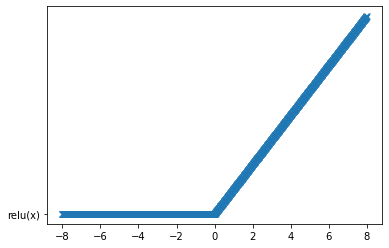

In [1]:
%matplotlib inline
import torch
from matplotlib import pyplot as plt

x = torch.arange(-8.0, 8.0, step=0.01, requires_grad=True)
y = torch.relu(x)
plt.plot(x.detach(), y.detach(), 'x', 'relu(x)',)

当输入为负时，Relu函数的导数为0，输入为正时，导数为1，输入等于0时，不可导，因此在输入为0时，默认使用导数为0。

- sigmoid函数

$$sigmoid(x) = \frac{1}{1 + \exp(-x)}$$

sigmoid函数在输入低于某个阈值时取值0，输入超过阈值时取值1，当输出为二分类问题时，sigmoid函数非常适用。

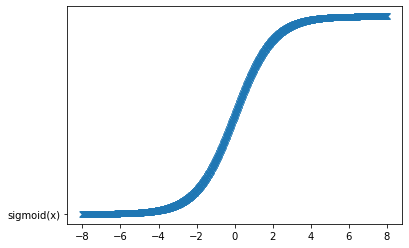

In [2]:
y = torch.sigmoid(x)
plt.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)',)

- tanh函数

$$
\operatorname{tanh}(x) = \frac{1-\exp(-2x)} {1+\exp(-2x)}
$$

函数的形状类似sigmoid函数，不同的是tanh函数关于坐标原点中心对称

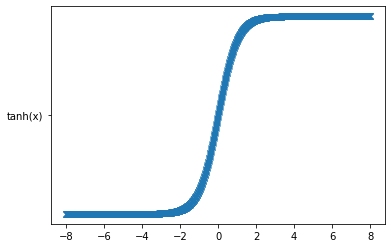

In [3]:
y = torch.tanh(x)
plt.plot(x.detach(), y.detach(), 'x', 'tanh(x)',)

## 从零实现MLP
为了与softmax对比，依然使用Fashion-MNIST数据集

In [4]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt

def get_fashion_mnist_labels(labels):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=".", train=True, transform=trans, download=False)
    mnist_test  = torchvision.datasets.FashionMNIST(root=".", train=False,transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
                 data.DataLoader(mnist_test,  batch_size, shuffle=True, num_workers=4))


batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 初始化模型参数
28\*28=784，即输入784个特征，输出为10个类别。

首先，实现一个具有单隐藏层的MLP，包含256个隐藏单元，因此该MLP架构为：
- 总层数为2（不计算输入层）
- 一层的隐藏层，该隐藏层有256个神经元
- 一个输出层，输出10个类别

*通常情况下选择2的n次幂作为层的宽度，计算更高效*

使用Pytorch张量来表示参数，每一层都拥有一个权重矩阵和一个偏置向量。

In [7]:
from torch import nn


num_inputs, num_outputs, num_hiddens = 784, 10, 256
# 第一层，即隐藏层：
# 输入为784，拥有256个神经元
# W1.shape = (784, 256), b1.shape = 256
W1 = nn.Parameter(
     torch.randn(num_inputs, num_hiddens, requires_grad=True) * 1e-2)
b1 = nn.Parameter(
     torch.zeros(num_hiddens, requires_grad=True))
# 第二层，即输出层
# 输入为256， 输出10个类别
# W2.shape = (256, 10), b2 = 10
W2 = nn.Parameter(
     torch.randn(num_hiddens, num_outputs, requires_grad=True) * 1e-2)
b2 = nn.Parameter(
     torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]


In [8]:
print(W1.shape, b1.shape)
print(W2.shape, b2.shape)

torch.Size([784, 256]) torch.Size([256])
torch.Size([256, 10]) torch.Size([10])


### 激活函数
此处使用Relu作为激活函数，使用最大值函数实现一个Relu函数：

In [9]:
def relu(X):
    zeros = torch.zeros_like(X)
    return torch.max(X, zeros)


### 模型
对于每个二维图像，忽略其维度结构，将每个图像视作784长度的向量

In [11]:
# X.shape = torch.Size([256, 1, 28, 28])
# y.shape = torch.Size([256])
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X.mm(W1) + b1)
    return (H.mm(W2) + b2)


In [12]:
loss = nn.CrossEntropyLoss()

### 训练
迭代周期设置为10， 学习率为0.1

In [14]:
num_epochs = 10
lr = 0.1
updater = torch.optim.SGD(params, lr=lr)

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
        
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                    float(l) * len(y), accuracy(y_hat, y),
                    y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
    train_loss, train_acc = train_metrics
    
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [15]:
def predict_ch3(net, test_iter, n=6):
    for X,y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + ',' + pred for true, pred in zip(trues, preds)]
    return trues, preds
    
t, p = predict_ch3(net, test_iter)
wrong = 0
for i, j in zip(t, p):
    if i != j:
        wrong += 1


In [17]:
print(wrong)
print(1-wrong/batch_size)

45
0.82421875
